2019-07-01 - Last Month Result: 0.00%
PORTFOLIO VALUE:  10000.0
2019-08-01 - Last Month Result: -0.52%
PORTFOLIO VALUE:  9947.935359961008
2019-09-03 - Last Month Result: 2.62%
PORTFOLIO VALUE:  10208.194619958405
2019-10-01 - Last Month Result: -5.11%
PORTFOLIO VALUE:  9686.970809900493
2019-11-01 - Last Month Result: 2.93%
PORTFOLIO VALUE:  9971.019019853526
2019-12-02 - Last Month Result: -0.02%
PORTFOLIO VALUE:  9969.214783816793
2020-01-02 - Last Month Result: 8.25%
PORTFOLIO VALUE:  10791.230258801168
2020-02-03 - Last Month Result: -0.85%
PORTFOLIO VALUE:  10699.400183773905
2020-03-02 - Last Month Result: -0.52%
PORTFOLIO VALUE:  10643.878800768474
2020-04-01 - Last Month Result: 2.08%
PORTFOLIO VALUE:  10865.437478751857
2020-05-01 - Last Month Result: 0.95%
PORTFOLIO VALUE:  10968.84775866419
2020-06-01 - Last Month Result: -1.73%
PORTFOLIO VALUE:  10779.200098263917
2020-07-01 - Last Month Result: 5.73%
PORTFOLIO VALUE:  11396.742420253137
2020-08-03 - Last Month Result: 12.

Start date,2019-07-01
End date,2020-12-01
Total months,17
,Backtest
Annual return,43.2%
Cumulative returns,67.1%
Annual volatility,19.6%
Sharpe ratio,1.93
Calmar ratio,4.99
Stability,0.81
Max drawdown,-8.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.67,2020-09-02,2020-09-08,2020-10-05,24
1,7.39,2020-06-08,2020-06-11,2020-07-06,21
2,7.30,2019-09-05,2019-10-02,2019-12-12,71
3,7.14,2020-02-19,2020-02-27,2020-03-16,19
4,6.68,2020-10-15,2020-10-30,2020-11-05,16


Stress Events,mean,min,max
New Normal,0.15%,-5.71%,4.13%


Top 10 long positions of all time,max
sid,
TIF,25.61%
TGT,13.98%
ETR,13.54%
AAPL,13.22%
WHR,11.83%
DE,11.74%
ALGN,11.19%
CINF,11.04%
PYPL,10.90%


Top 10 short positions of all time,max
sid,
TIF,-25.68%
SWKS,-3.31%
STT,-3.22%
QRVO,-2.95%
ALGN,-2.33%
WDC,-1.70%
APA,-1.02%


Top 10 positions of all time,max
sid,
TIF,25.68%
TGT,13.98%
ETR,13.54%
AAPL,13.22%
WHR,11.83%
DE,11.74%
ALGN,11.19%
CINF,11.04%
PYPL,10.90%


Annualized Return: 43.24% Max Drawdown: -8.67%


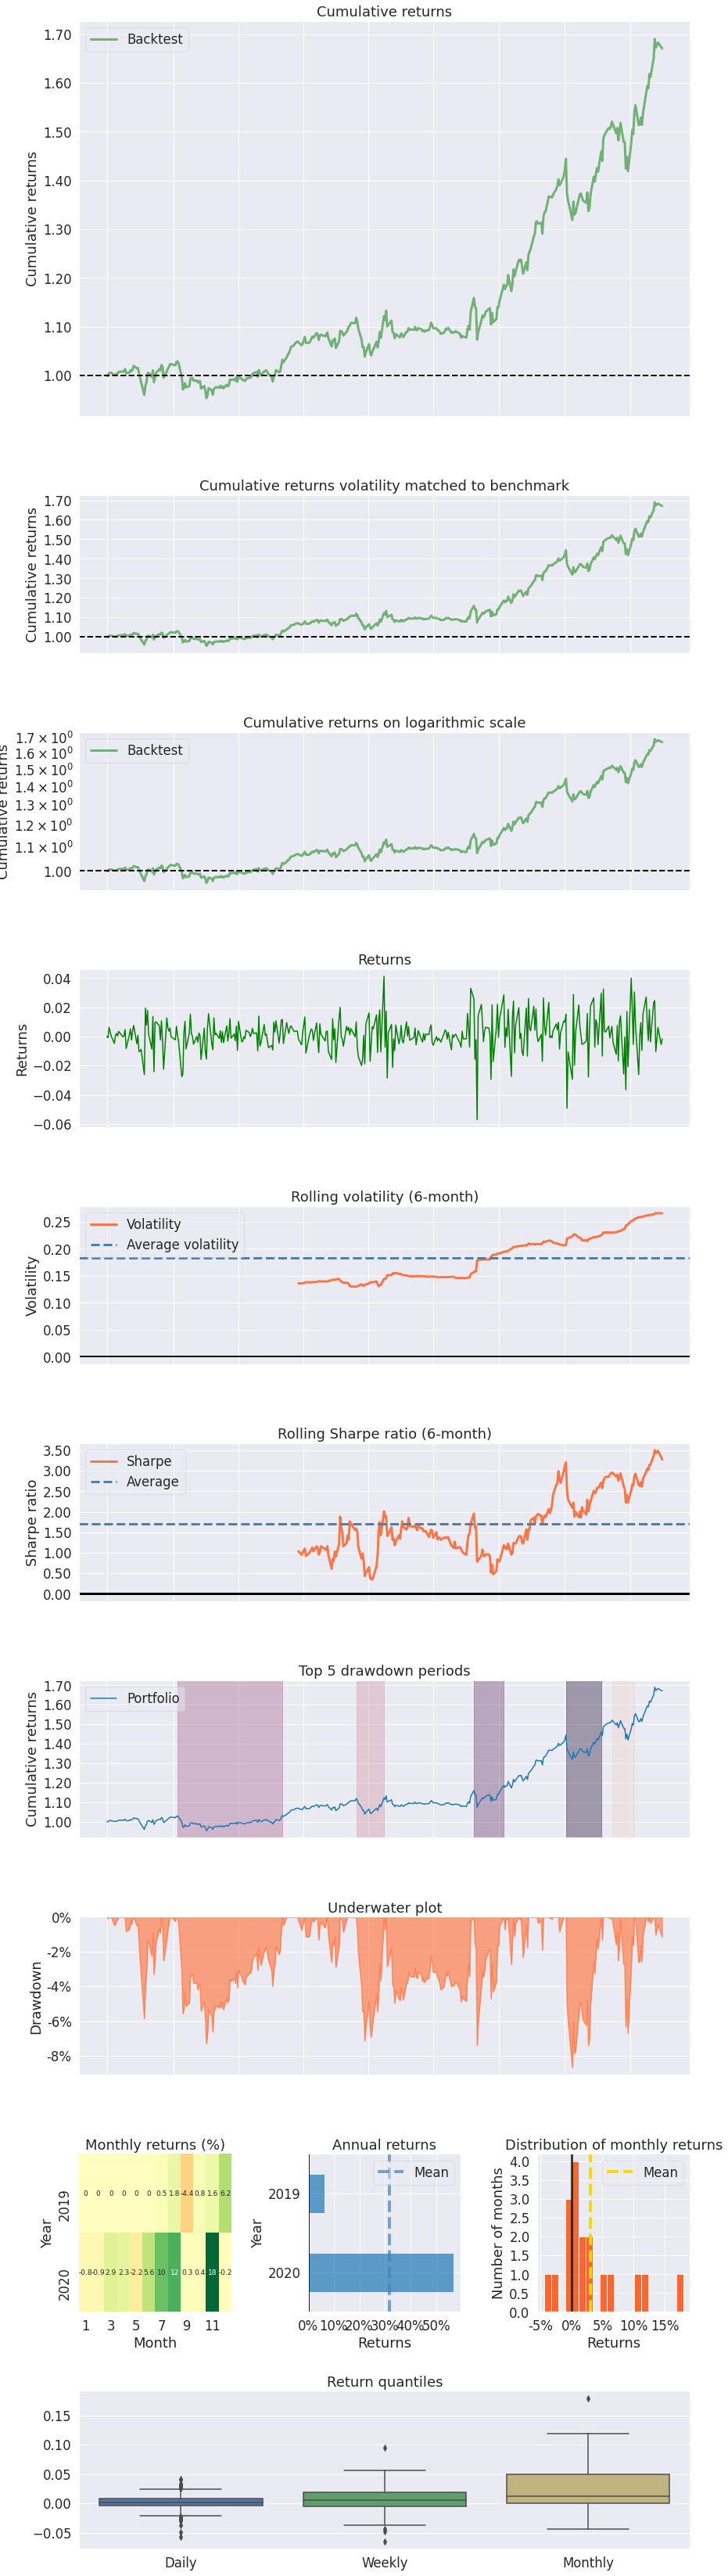

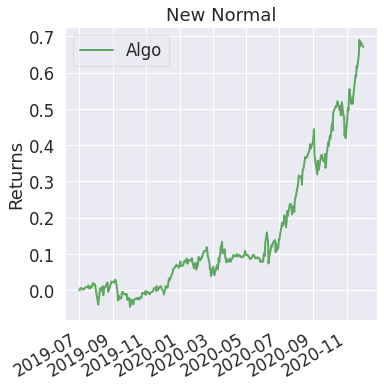

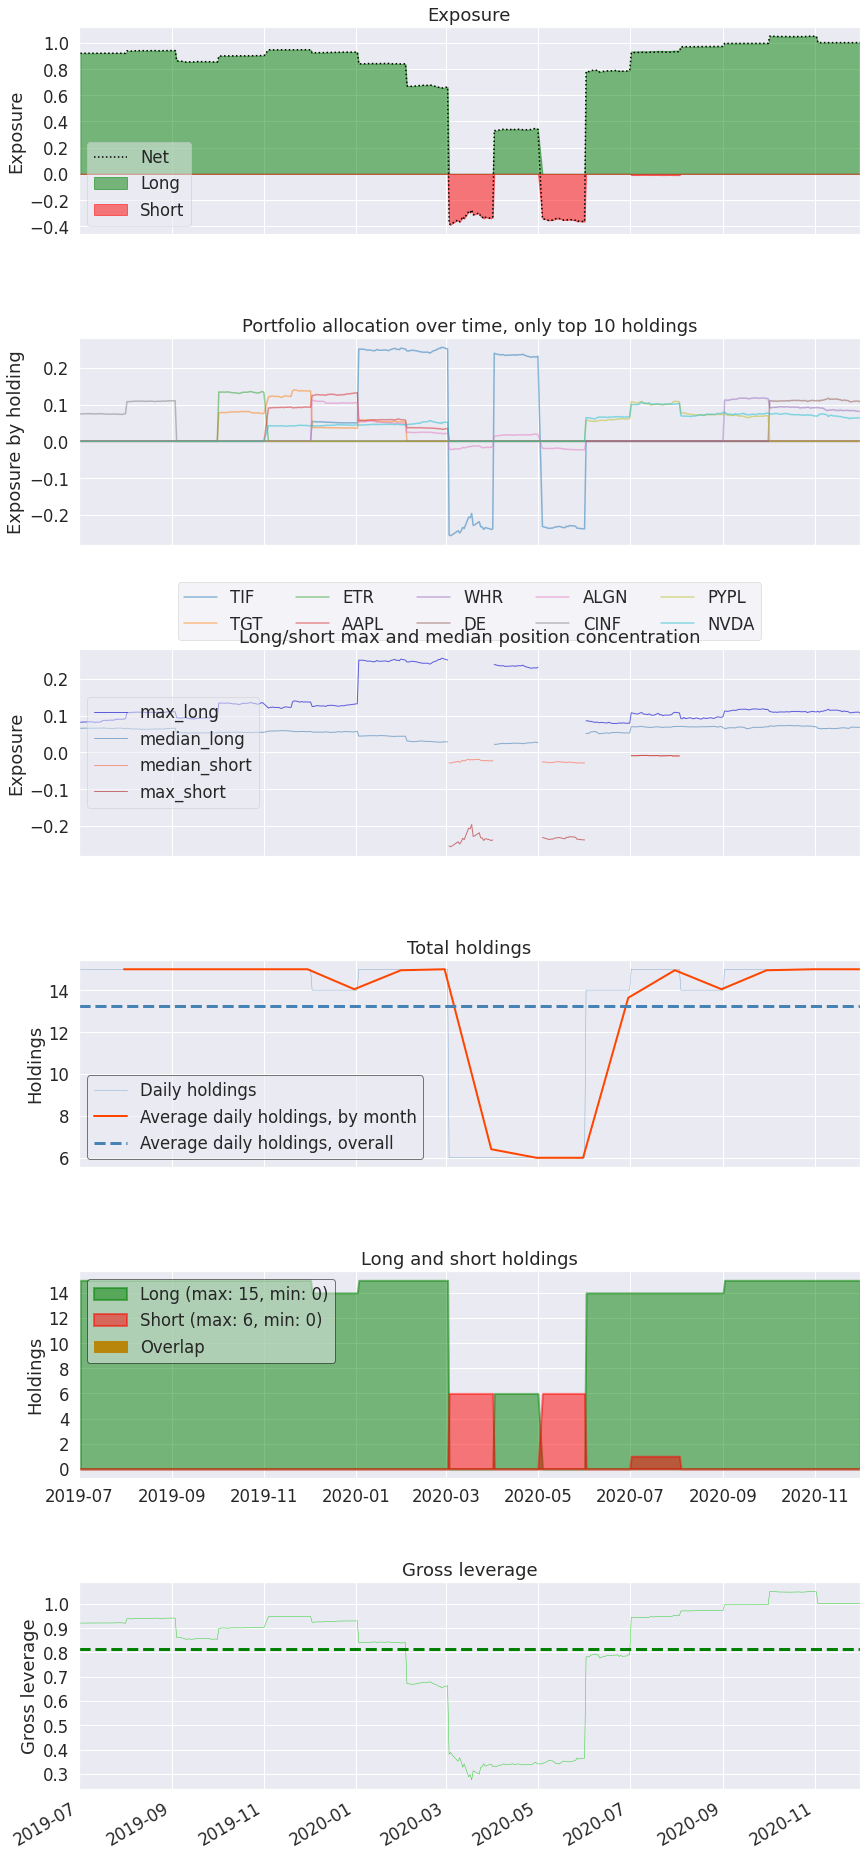

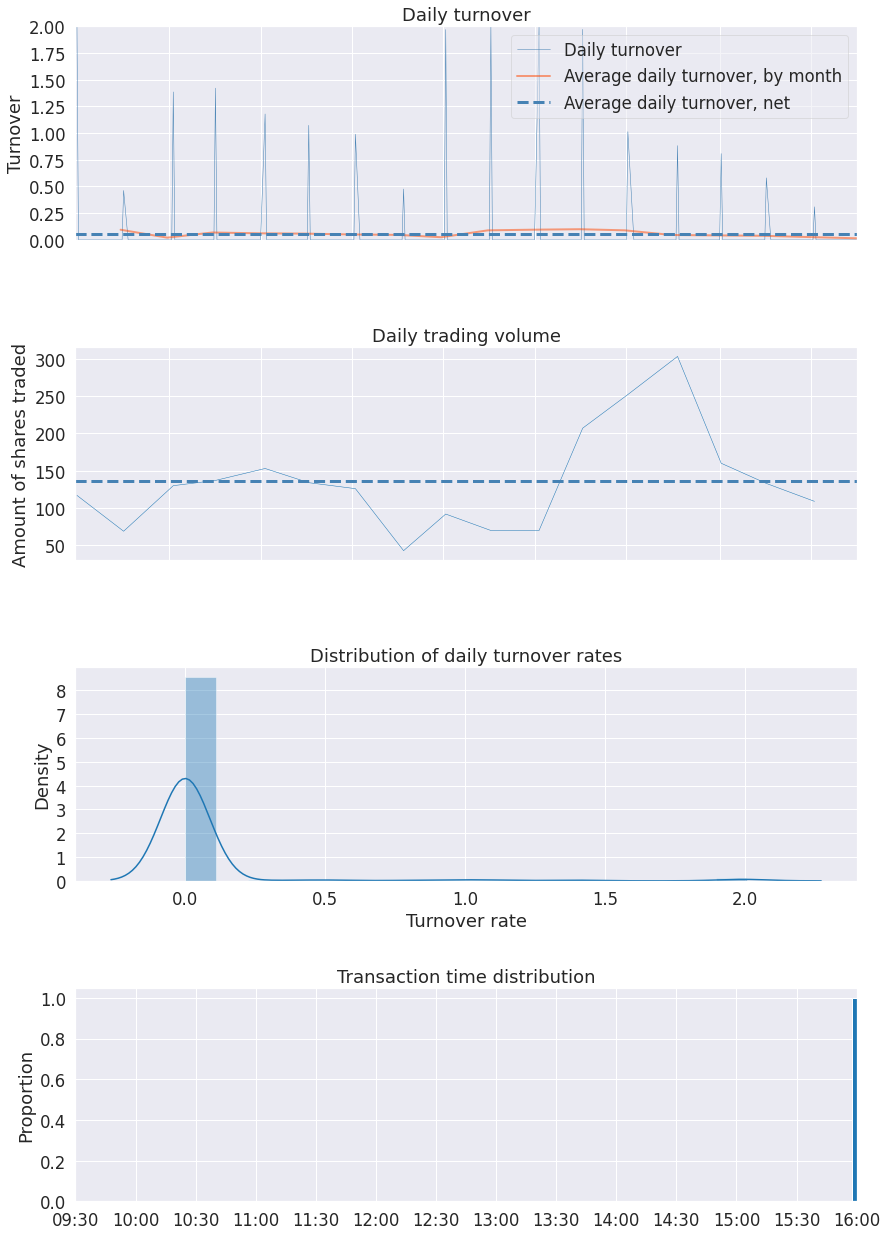

In [1]:
%matplotlib inline

import zipline
from zipline.api import order_target_percent, symbol,  \
    set_commission, set_slippage, schedule_function, \
    date_rules, time_rules
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import pyfolio as pf
import pandas as pd
import numpy as np  
from scipy import stats  
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage


import warnings
warnings.filterwarnings("ignore")

"""
Model Settings
"""
intial_portfolio = 10000
momentum_window_far = 120
momentum_window_near = 60
minimum_momentum = 60
portfolio_size = 15
vola_window = 20
exclude_days = 5

# Trend filter settings
enable_trend_filter = True
trend_filter_symbol = 'SPY'
trend_filter_window_far = 120
trend_filter_window_near = 60

"""
Commission and Slippage Settings
"""
enable_commission = True
commission_pct = 0.001
enable_slippage = True 
slippage_volume_limit = 0.025
slippage_impact = 0.05

"""
Helper functions.
"""

def momentum_score(ts):
    """
    Input:  Price time series.
    Output: Annualized exponential regression slope, 
            multiplied by the R2
    """
    x = np.arange(len(ts)) 
    log_ts = np.log(ts) 
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    annualized_slope = (np.power(np.exp(slope), 252) - 1) * 100
    return annualized_slope * (r_value ** 2)

def volatility(ts):
    return ts.pct_change().rolling(vola_window).std().iloc[-1]

"""
Initialization and trading logic
"""
def initialize(context):
   
    # Set commission and slippage.
    if enable_commission:
        comm_model = PerDollar(cost=commission_pct)
    else:
        comm_model = PerDollar(cost=0.0)
    set_commission(comm_model)
    
    if enable_slippage:
        slippage_model = VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)
        set_slippage(slippage_model)
    else:
        slippage_model = FixedSlippage(spread=0.0)        
    
    # Used only for progress output.
    context.last_month = intial_portfolio
    
    # Store index membership
    sp500_table = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies", header=0)[0]
    context.index_members = list(sp500_table.loc[:, "Symbol"])
    
    #Schedule rebalance monthly.
    schedule_function(
        func=rebalance,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    )
    
def output_progress(context):
    """
    Output some performance numbers during backtest run
    """
    
    # Get today's date
    today = zipline.api.get_datetime().date()

    # Calculate percent difference since last month
    perf_pct = (context.portfolio.portfolio_value / context.last_month) - 1
    # Print performance, format as percent with two decimals.
    print("{} - Last Month Result: {:.2%}".format(today, perf_pct))
    # Remember today's portfolio value for next month's calculation
    context.last_month = context.portfolio.portfolio_value

    # Get portfolio value and positions for this day
    port_value = context.portfolio.portfolio_value
    day_positions = context.portfolio.positions

    # Empty DataFrame to store values
    df = pd.DataFrame(columns=['value', 'amount'])

    # Populate DataFrame with position info
    for k, v in day_positions.items():
        ticker = k.symbol 
        df.loc[ticker,'value'] = v.amount * v.last_sale_price
        df.loc[ticker,'amount'] = v.amount
    
    # Add cash position
    cash = port_value - df['value'].sum()
    if cash < 0:
        cash = 0
    df.loc['cash', ['value','amount']] = [cash, 0] 
    print("PORTFOLIO VALUE: ", df['value'].sum())

    # Make pie chart for allocations
    """fig, ax1 = plt.subplots(figsize=[12, 10])
    ax1.pie(df['value'], labels=df.index, shadow=True, startangle=90)
    ax1.axis('equal')
    ax1.set_title('Allocation on {}'.format(today))
    plt.show()"""

    
def rebalance(context, data):
    # Write some progress output during the backtest
    output_progress(context)
    
    # Check which stocks are part of the index today. Data prefetched earlier.
    today = zipline.api.get_datetime()#.date()
    
    delete = ["BRK-B", "BRK.B", "BF.B", "BF-B"]
    # Finally, get the Zipline symbols for the tickers
    todays_universe = [
        symbol(ticker)
        for ticker in context.index_members
        if ticker not in delete
    ]

    # Check how long history window we need.
    hist_window = max(momentum_window_near,
                      momentum_window_far) + exclude_days

    # Check how long history window we need.
    hist_window = max(momentum_window_near,
                      momentum_window_far) + exclude_days

    # Get historical data
    hist = data.history(todays_universe, "close", hist_window, "1d")
    
    # Slice the history to match the two chosen time frames.
    momentum_hist1 = hist[(-1 * momentum_window_near):]
    momentum_hist2 = hist[(-1 * momentum_window_far):]
    
    # Calculate momentum values for the two time frames.
    momentum_list1 = momentum_hist1.apply(momentum_score)  
    momentum_list2 = momentum_hist2.apply(momentum_score) 
    
    # Now let's put the two momentum values together, and calculate mean.
    momentum_concat = pd.concat((momentum_list1, momentum_list2))
    mom_by_row = momentum_concat.groupby(momentum_concat.index)
    mom_means = mom_by_row.mean()
    
    # Sort by momentum value.
    ranking_table = mom_means.sort_values(ascending=False)
    #minimum_momentum_for_kept = ranking_table[:portfolio_size].mean()

    """
    Sell Logic
    
    First we check if any existing position should be sold.
    * Sell if stock is no longer part of index.
    * Sell if stock has too low momentum value.
    * Sell if stock is lower 100MA
    * Sell if stock not in top 100 stocks
    """
    kept_positions = list(context.portfolio.positions.keys())
    sold = []
    for security in context.portfolio.positions:
        sec_hist = data.history(
            security, 
            'close', 
            100, 
            '1d'
        )
        if (security not in todays_universe):
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
            sold.append(security.symbol)
        elif ranking_table[security] < minimum_momentum:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
            sold.append(security.symbol)
        elif sec_hist.iloc[-1] < sec_hist.mean():
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
            sold.append(security.symbol)
        elif security not in ranking_table[:50]:
            order_target_percent(security, 0.0)
            kept_positions.remove(security)
            sold.append(security.symbol)
    
    """
    Trend Filter Section
    """
    if enable_trend_filter:
        ind_hist = data.history(
            symbol(trend_filter_symbol), 
            'close', 
            trend_filter_window_far, 
            '1d'
        )
        
        ind_hist2 = data.history(
            symbol(trend_filter_symbol), 
            'close', 
            trend_filter_window_near, 
            '1d'
        )
        
        bull_market = ind_hist.iloc[-1] > ind_hist.mean()
        if not bull_market:
            # Check wheather this is due to distant dips
            bull_market = ind_hist2.mean() > ind_hist.mean() and ind_hist.iloc[-1] > ind_hist2.mean()
        if bull_market == False:
            for security in context.portfolio.positions:
                order_target_percent(security, 0.0)
            return    
    
    """
    Stock Selection Logic
    
    Check how many stocks we are keeping from last month.
    Fill from top of ranking list, until we reach the
    desired total number of portfolio holdings.
    """
    replacement_stocks = portfolio_size - len(kept_positions)
    buy_list = ranking_table.loc[
        ~ranking_table.index.isin(kept_positions)][:replacement_stocks]
    
    new_portfolio = pd.concat(
        (buy_list, 
         ranking_table.loc[ranking_table.index.isin(kept_positions)])
    )
    

    """
    Calculate inverse volatility for stocks, 
    and make target position weights.
    """
    vola_table = hist[new_portfolio.index].apply(volatility)
    inv_vola_table = 1 / vola_table 
    sum_inv_vola = np.sum(inv_vola_table)         
    vola_target_weights = inv_vola_table / sum_inv_vola
    vola_target_weights = vola_target_weights.clip(upper=.25)
    
    equity_weight = 0.0
    
    for security, rank in new_portfolio.iteritems():
        weight = vola_target_weights[security]
        if security in kept_positions:
            #print("ORDRING {} of {}".format(weight * 100, security.symbol))
            order_target_percent(security, weight)
        else:
            if ranking_table[security] > minimum_momentum:
                #print("ORDRING {} of {}".format(weight * 100, security.symbol))
                order_target_percent(security, weight)
        equity_weight += weight
    
    day_positions = context.portfolio.positions
    port_value = context.portfolio.portfolio_value
    
    # Empty DataFrame to store values
    df = pd.DataFrame(columns=['value', 'amount'])
    
    # Populate DataFrame with position info
    for k, v in day_positions.items():
        ticker = k.symbol 
        df.loc[ticker,'value'] = v.amount * v.last_sale_price
        df.loc[ticker,'amount'] = v.amount


def analyze(context, perf):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_full_tear_sheet(returns, 
                              positions=positions, 
                              transactions=transactions,
                             )
    
    perf['max'] = perf.portfolio_value.cummax()
    perf['dd'] = (perf.portfolio_value / perf['max']) - 1
    maxdd = perf['dd'].min()
    ann_ret = (np.power((perf.portfolio_value.iloc[-1] / perf.portfolio_value.iloc[0]),(252 / len(perf)))) - 1
    
    print("Annualized Return: {:.2%} Max Drawdown: {:.2%}".format(ann_ret, maxdd))

    return   
        
start = pd.to_datetime('2019-7-1', utc=True)
end = pd.to_datetime('2020-12-1', utc=True)
perf = zipline.run_algorithm(
    start=start, end=end, 
    initialize=initialize, 
    analyze=analyze, 
    capital_base=intial_portfolio,  
    data_frequency = 'daily', 
    bundle='yahoo_direct') 



In [ ]:
context.portfolio.portfolio_value
